### Exploration Exercises

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [23]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

In [25]:
df.createOrReplaceTempView('df')


### How many different cases are there, by department?


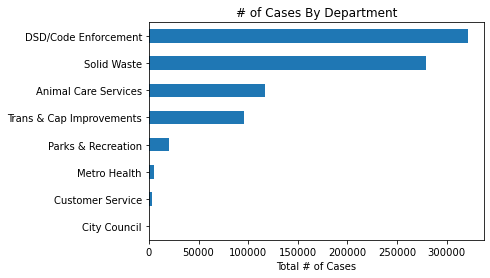

In [21]:
(
    df.groupby("department")
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values()
    .plot.barh()
)
plt.gca().set(
    ylabel="", xlabel="Total # of Cases", title="# of Cases By Department"
);

### Does the percentage of cases that are late vary by department?

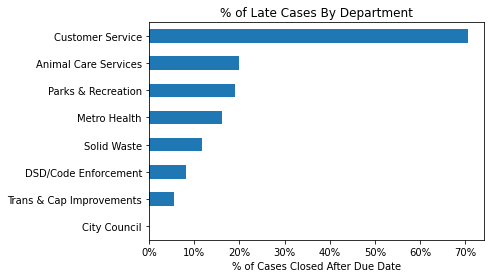

In [24]:
(
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("p_cases_late"))
    .toPandas()
    .set_index("department")
    .p_cases_late.sort_values()
    .plot.barh()
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter("{:.0%}".format))
plt.gca().set(
    ylabel="",
    xlabel="% of Cases Closed After Due Date",
    title="% of Late Cases By Department",
);

In [20]:
(
    df.filter('case_late').groupby('department').count().withColumn('pct', 'count' / df.filter('case_late').count() )
)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

### On average, how late are the late cases by department?


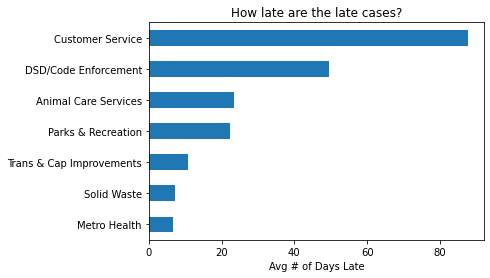

In [27]:
(
    df.filter("case_late")
    .groupby("department")
    .agg(avg("num_days_late").alias("avg_days_late"))
    .toPandas()
    .set_index("department")
    .avg_days_late.sort_values()
    .plot.barh()
)

plt.gca().set(
    ylabel="",
    xlabel="Avg # of Days Late",
    title="How late are the late cases?",
);

### What is the service type that is the most late? Just for Parks & Rec?


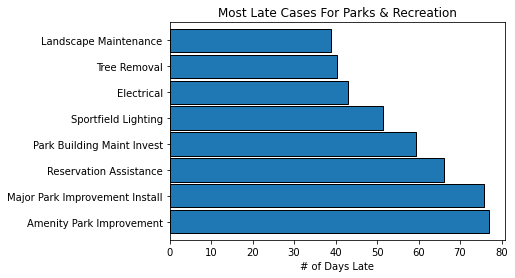

In [26]:
(
    df.filter(df.case_late)
    .filter(df.department == "Parks & Recreation") # comment out this line to see all
    .groupby("service_request_type")
    .agg(mean("num_days_late").alias("avg_days_late"))
    .sort(desc("avg_days_late"))
    .limit(8)  # limit in spark, not pandas
    .toPandas()
    .set_index("service_request_type")
    .avg_days_late
    .plot.barh(ec="black", width=0.9)
)

plt.gca().set(
    title="Most Late Cases For Parks & Recreation",
    xlabel="# of Days Late",
    ylabel="",
);

### For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

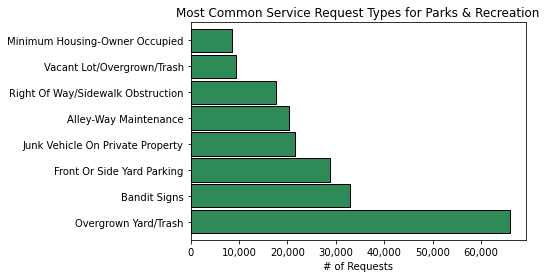

In [28]:
(
    df.filter(expr('department == "DSD/Code Enforcement"'))
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(color="seagreen", width=0.9, ec="black")
)

plt.gca().set(
    ylabel="",
    xlabel="# of Requests",
    title="Most Common Service Request Types for Parks & Recreation",
)

plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:,.0f}'.format))

### Does whether or not its a weekend matter for when a case is opened/closed?


[Text(0.5, 0, ''),
 Text(0, 0.5, '# Cases'),
 Text(0.5, 1.0, 'Total # of Cases Opened By Weekday')]

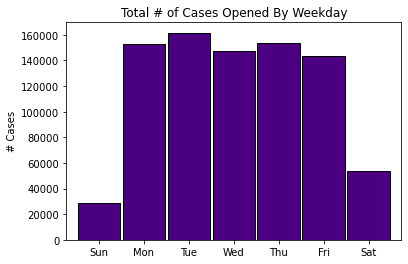

In [29]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    # the line above is an example of doing the date formatting with spark
    # through the SimpleDateFormat api instead of with python
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    # Here we convert the weekday string to a categorical type with an order.
    # This lets us order the weekdays properly in our visualization.
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar(width=0.95, ec="black", color="indigo")
)

plt.xticks(rotation=0)
plt.gca().set(
    xlabel="", ylabel="# Cases", title="Total # of Cases Opened By Weekday"
)

### On average, how many cases are opened a day for the Customer Service department?


In [30]:
(
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
    ['count'].mean()
 )

5.564453125

### Does the number of service requests for the solid waste department vary by day of the week?``

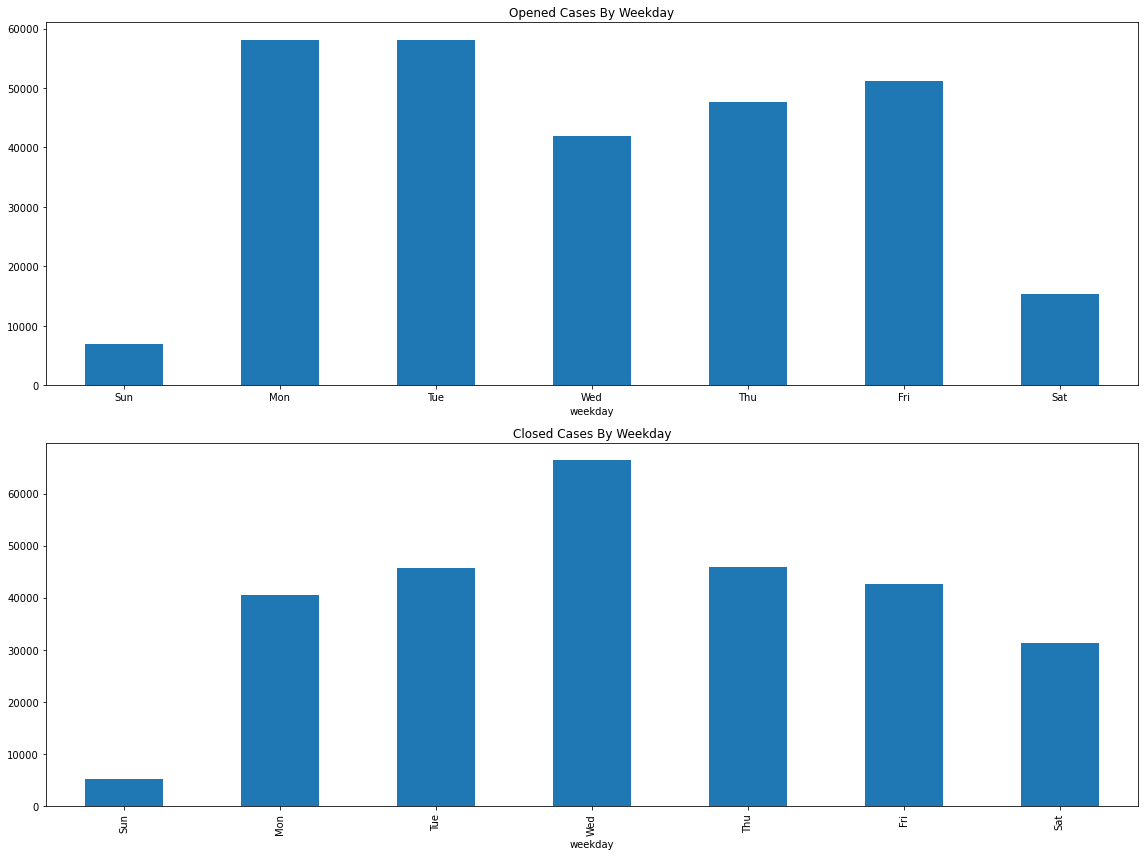

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax1)
)
ax1.set(
    title='Opened Cases By Weekday'
)
ax1.tick_params(axis='x', labelrotation=0)


(
    df.withColumn("weekday", date_format("case_closed_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax2)
)
ax2.set(
    title='Closed Cases By Weekday'
)
fig.tight_layout()